In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import spearmanr
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering, BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
pca = PCA()
le = LabelEncoder()
ss = StandardScaler()
Kmeans = KMeans(2,n_init=5)
Agglomerative_Clustering = AgglomerativeClustering(2,metric="euclidean")
bisect_means = BisectingKMeans(n_clusters=2)

In [3]:
votes = pd.read_csv('fantom_grant_votes.csv')
votes.rename(columns={'amount': 'funding_amount','created_at':'Funded_at'}, inplace=True)
votes['No_Grants_Funded'] = votes.groupby('source_wallet')['source_wallet'].transform('count')


data = pd.read_csv('fantom_data_queried.csv')
data['last_trasaction_date'] = pd.to_datetime(data['last_trasaction_date'])
data['first_transaction_date'] = pd.to_datetime(data['first_transaction_date'])


In [5]:
merged_df = pd.merge(data, votes , on='source_wallet', how='left')\
    .drop(['id'],axis =1)

merged_df['first_transaction_date'] = pd.to_datetime(merged_df['first_transaction_date'])
merged_df['last_trasaction_date'] = pd.to_datetime(merged_df['last_trasaction_date'])
merged_df['Funded_at'] = pd.to_datetime(merged_df['Funded_at'])
merged_df = merged_df.loc[merged_df['No_Grants_Funded']==1]

In [10]:
X = merged_df.copy()
Main_df=X.copy()
Main_df['Funded_at'] = Main_df['Funded_at'].dt.date

In [11]:
X['first_transaction_date_day'] = X['first_transaction_date'].dt.day
X['first_transaction_date_month'] = X['first_transaction_date'].dt.month
X['first_transaction_date_year'] = X['first_transaction_date'].dt.year

X['Funded_at_day'] = X['Funded_at'].dt.day
X['Funded_at_month'] = X['Funded_at'].dt.month
X['Funded_at_year'] = X['Funded_at'].dt.year

X['last_trasaction_date_day'] = X['last_trasaction_date'].dt.day
X['last_trasaction_date_month'] = X['last_trasaction_date'].dt.month
X['last_trasaction_date_year'] = X['last_trasaction_date'].dt.year

X.drop(['first_transaction_date','Funded_at','last_trasaction_date'],axis =1,inplace=True)

In [12]:
X.drop_duplicates('source_wallet',inplace=True)

X_numeric = X[X.select_dtypes(include=['int64', 'float64']).columns]

X_scaled = ss.fit_transform(X_numeric)

X_scaled = pd.DataFrame(X_scaled, columns=X_numeric.columns)

<AxesSubplot: >

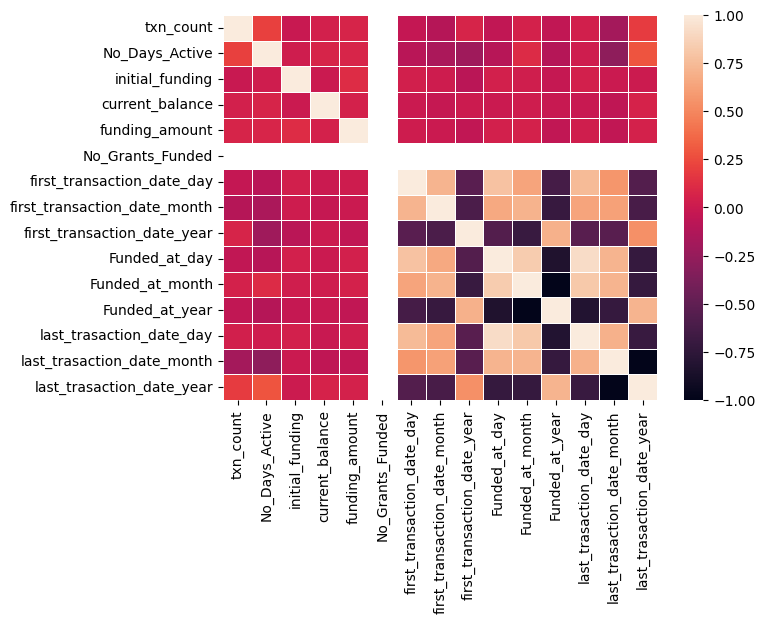

In [15]:
plt.figure(figsize=(7,5))
sns.heatmap(data = X_scaled.corr(numeric_only=True), fmt='g', linewidths=.5, cbar=True)

In [16]:
X_pca_1 = pca.fit_transform(X_scaled)

In [17]:
labels1 = Kmeans.fit_predict(X_pca_1)
Counter(labels1)

Counter({0: 4280, 1: 803})

In [18]:
labels2 = Agglomerative_Clustering.fit_predict(X_pca_1)
Counter(labels2)

Counter({0: 4285, 1: 798})

In [21]:
labels3 = bisect_means.fit_predict(X_pca_1)
Counter(labels3)

Counter({0: 4280, 1: 803})

In [22]:
lists = [labels1, labels2,labels3]
corr_matrix = np.corrcoef(lists)
print(corr_matrix)

[[1.         0.99630003 1.        ]
 [0.99630003 1.         0.99630003]
 [1.         0.99630003 1.        ]]


In [23]:
majority_vote = []

for i, j, k in zip(labels1, labels2, labels3):
    count_i = [i, j, k].count(i)
    count_j = [i, j, k].count(j)
    count_k = [i, j, k].count(k)
    if count_i >= count_j and count_i >= count_k:
        majority_vote.append(i)
    elif count_j >= count_i and count_j >= count_k:
        majority_vote.append(j)
    else:
        majority_vote.append(k)

In [24]:
X['Sybil_status'] = majority_vote

In [25]:
X['Sybil_status'].value_counts()

0    4280
1     803
Name: Sybil_status, dtype: int64

In [26]:
Sybil_df =X[X['Sybil_status']==1]

In [29]:
Sybil_data = Sybil_df.loc[(Sybil_df['txn_count']<=3)&(Sybil_df['No_Days_Active']<=5)]

In [30]:
Sybil_df.to_csv('Fantom_sybil.csv',index  =False)